In [21]:
import pandas as pd

from orion.data import load_signal, load_anomalies

# 1. Data

In [22]:
signal_name = 'S-1'

data = load_signal(signal_name)

anomalies = load_anomalies(signal_name)

data.head()

,timestamp,value
0,1222819200,-0.366359
1,1222840800,-0.394108
2,1222862400,0.403625
3,1222884000,-0.362759
4,1222905600,-0.370746


# 2. Pipeline

In [23]:
from mlblocks import MLPipeline

pipeline_name = 'UniTS'

pipeline = MLPipeline(pipeline_name)

## step by step execution

MLPipelines are compose of a squence of primitives, these primitives apply tranformation and calculation operations to the data and updates the variables within the pipeline. To view the primitives used by the pipeline, we access its `primtivies` attribute. 

The `UniTS` contains 6 primitives. we will observe how the `context` (which are the variables held within the pipeline) are updated after the execution of each primitive.

In [24]:
pipeline.primitives

['mlstars.custom.timeseries_preprocessing.time_segments_aggregate',
 'sklearn.impute.SimpleImputer',
 'sklearn.preprocessing.StandardScaler',
 'orion.primitives.units.UniTS',
 'orion.primitives.timeseries_errors.regression_errors',
 'orion.primitives.timeseries_anomalies.find_anomalies']

### time segments aggregate
this primitive creates an equi-spaced time series by aggregating values over fixed specified interval.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**:
    - `X` sequence of aggregated values, one column for each aggregation method.
    - `index` sequence of index values (first index of each aggregated segment).

In [25]:
context = pipeline.fit(data, output_=0)
context.keys()

dict_keys(['X', 'index'])

In [26]:
for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1222819200 has value [-0.36635895]
entry at 1222840800 has value [-0.39410778]
entry at 1222862400 has value [0.4036246]
entry at 1222884000 has value [-0.36275906]
entry at 1222905600 has value [-0.37074649]


### SimpleImputer
this primitive is an imputation transformer for filling missing values.
* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `X` which is a transformed version of X.

In [27]:
step = 1

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X'])

### StandardScaler
this primitive transforms features by scaling each feature to a given range.
* **input**: `X` the data used to compute the per-feature mean and standard deviation used for later scaling along the features axis.
* **output**: `X` which is a transformed version of X.

In [28]:
step = 2

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X'])

In [29]:
# after scaling the data between [-1, 1]

for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1222819200 has value [-0.4818325]
entry at 1222840800 has value [-0.54231192]
entry at 1222862400 has value [1.19636972]
entry at 1222884000 has value [-0.47398644]
entry at 1222905600 has value [-0.49139529]


### UniTS
this is a forecasting using UniTS. you can read more about it in the [related paper](https://arxiv.org/abs/2403.00131).

* **input**: 
    - `X` n-dimensional array containing the input sequences for the model.
* **output**: 
    - `y_hat` predicted values
    - `y` actual values
    - `index` indices sequence.

In [30]:
step = 3

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

100%|██████████| 9899/9899 [02:13<00:00, 74.20it/s]


dict_keys(['index', 'X', 'y_hat', 'y'])

In [31]:
context['y'].shape

(9899, 1)

### regression errors

this primitive computes an array of errors comparing predictions and expected output.

* **input**: 
    - `y` ground truth.
    - `y_hat` forecasted values.
* **output**: `errors` array of errors.

In [32]:
step = 4

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'y_hat', 'X', 'y', 'errors'])

### find anomalies

this primitive finds anomalies from sequence of errors

* **input**: 
    - `errors` array of errors
    - `index` indices
* **output**: `anomalies`.

In [33]:
step = 5

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'y_hat', 'errors', 'X', 'y', 'anomalies'])

In [34]:
context['anomalies']

array([[1.22821920e+09, 1.22938560e+09, 3.99242622e-01],
       [1.39827600e+09, 1.40836320e+09, 3.90981345e-01]])

In [35]:
import matplotlib.pyplot as plt

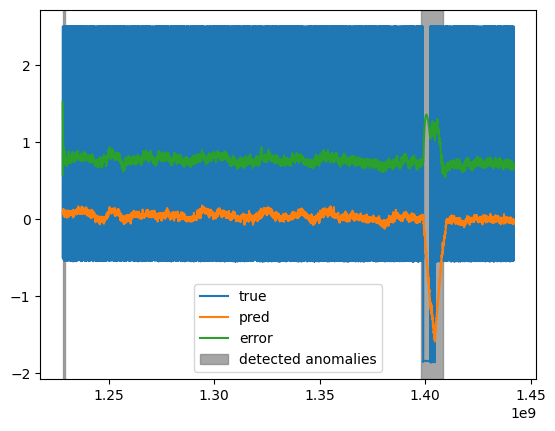

In [36]:
plt.plot(context['index'], context['y'], label= "true")
plt.plot(context['index'], context['y_hat'], label = 'pred')
plt.plot(context['index'], context['errors'], label = 'error')
for ano in context['anomalies']: 
    plt.axvspan(ano[0], ano[1], alpha = 0.7, color = 'grey')
plt.legend(["true", "pred","error", "detected anomalies"])


## 3. Evaluate performance

In this next step we will load some already known anomalous intervals and evaluate how
good our anomaly detection was by comparing those with our detected intervals.

For this, we will first load the known anomalies for the signal that we are using:

In [37]:
from orion.data import load_anomalies

ground_truth = load_anomalies('S-1')
ground_truth

,start,end
0,1398168000,1407823200


In [38]:
anomalies = []
for ano in context['anomalies']:
    anomalies.append((ano[0], ano[1]))
anomalies

[(1228219200.0, 1229385600.0), (1398276000.0, 1408363200.0)]

In [39]:
from orion.evaluation import contextual_confusion_matrix, contextual_f1_score

start, end = context['index'][0], context['index'][-1]

contextual_confusion_matrix(ground_truth, anomalies, start = start, end = end, weighted=False)

(None, 1, 0, 1)

In [40]:
contextual_f1_score(ground_truth, anomalies, start = start, end = end, weighted=False)

0.6666666666666666